### Building a Model To predict Emails Open Rates (OR%) , Based on the following Features 
- Time ( month of the year , quarter of the year , day of the week )
- Pirority of email , main or reminder 
- Category ( interval , final )
- Number of emails sent in each subject
- Constructed Features
 - Length of the subject 
 - Personalization of Email
 - Having emoji or not
 - Casual tone or formal 
 - Urgency at the subject 
 - Metion of price or discount in the subject 
 - Imperative tone in the subject 
 - Mention of product in the subject

In [1]:
#importing libraries 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import statsmodels.api as sm
import matplotlib.pyplot as plt


In [2]:
#r reading the data as a dataframe
df = pd.read_csv("model_data.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1279 entries, 0 to 1278
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Sent date          1279 non-null   object 
 1   DD                 1279 non-null   object 
 2   Category name      1279 non-null   object 
 3   Main vs REM        1279 non-null   object 
 4   Subject            1279 non-null   object 
 5   Sendings           1279 non-null   int64  
 6   OR clean %         1279 non-null   float64
 7   length of subject  1279 non-null   int64  
 8   Personalization    1279 non-null   int64  
 9   Emoji              1279 non-null   int64  
 10  Urgency            1279 non-null   int64  
 11  Tone               1279 non-null   int64  
 12  Price or Discount  1279 non-null   int64  
 13  imperative         1279 non-null   int64  
 14  product            1279 non-null   int64  
 15  Month              1279 non-null   int64  
 16  letter_count       1279 

In [4]:
columns_to_drop = [ "translation", "CTR clean %","Date","Month","Subject"]  
df = df.drop(columns=columns_to_drop, errors='ignore')

In [5]:
# Convert to datetime
df['Sent date'] = pd.to_datetime(df['Sent date'], errors='coerce')

# Create a Month column (numeric)
df['Month'] = df['Sent date'].dt.month


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1279 entries, 0 to 1278
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Sent date          1279 non-null   datetime64[ns]
 1   DD                 1279 non-null   object        
 2   Category name      1279 non-null   object        
 3   Main vs REM        1279 non-null   object        
 4   Sendings           1279 non-null   int64         
 5   OR clean %         1279 non-null   float64       
 6   length of subject  1279 non-null   int64         
 7   Personalization    1279 non-null   int64         
 8   Emoji              1279 non-null   int64         
 9   Urgency            1279 non-null   int64         
 10  Tone               1279 non-null   int64         
 11  Price or Discount  1279 non-null   int64         
 12  imperative         1279 non-null   int64         
 13  product            1279 non-null   int64         
 14  letter_c

In [7]:
df.columns

Index(['Sent date', 'DD', 'Category name', 'Main vs REM', 'Sendings',
       'OR clean %', 'length of subject', 'Personalization', 'Emoji',
       'Urgency', 'Tone', 'Price or Discount', 'imperative ', 'product',
       'letter_count', 'Month'],
      dtype='object')

In [8]:
categorical_columns = [
    'DD',
    'Category name',
    'Main vs REM',
    'Personalization',
    'Emoji',
    'Urgency',
    'Tone',
    'Price or Discount',
    'imperative ',
    'product',
    'length of subject',
    'Month'
]

for col in categorical_columns:
    if col in df.columns:
        df[col] = df[col].astype('category')
    else:
        print(f"Warning: Column '{col}' not found in DataFrame.")


In [9]:
print(df.dtypes)


Sent date            datetime64[ns]
DD                         category
Category name              category
Main vs REM                category
Sendings                      int64
OR clean %                  float64
length of subject          category
Personalization            category
Emoji                      category
Urgency                    category
Tone                       category
Price or Discount          category
imperative                 category
product                    category
letter_count                  int64
Month                      category
dtype: object


In [ ]:
df.columns

In [12]:
# List the columns where you want to replace 1/0
cols_to_replace = ['Personalization',"Emoji",'Urgency',"Tone",'Price or Discount','imperative ','product']
  

# Replace 1 → 'yes' and 0 → 'no' in those columns
df[cols_to_replace] = df[cols_to_replace].replace({1: 'yes', 0: 'no'})
df['length of subject']=df['length of subject'].replace({1: "long", 0:"short"})

# (optional) ensure they are treated as categorical
df[cols_to_replace] = df[cols_to_replace].astype('category')

# Quick check
print(df[cols_to_replace].head())
print(df['length of subject'].head())



  Personalization Emoji Urgency Tone Price or Discount imperative  product
0              no    no      no   no               yes          no     yes
1              no    no      no   no                no          no     yes
2              no   yes      no  yes                no          no      no
3              no   yes     yes  yes               yes          no      no
4              no    no      no   no               yes          no     yes
0    short
1    short
2    short
3     long
4    short
Name: length of subject, dtype: category
Categories (2, object): ['short', 'long']


Next , I will confirm that the values in "OR clean %" is a valid percentage 

In [13]:
# Check if all values are between 0 and 1
valid_percentage = df['OR clean %'].between(0, 1).all()

if valid_percentage:
    print("All values in 'OR clean %' are valid percentages (0 to 1).")
else:
    # Show which rows are invalid
    invalid_rows = df[~df['OR clean %'].between(0, 1)]
    print("Some values are outside 0 to 1:")
    display(invalid_rows)


All values in 'OR clean %' are valid percentages (0 to 1).


In [14]:
import pandas as pd
import numpy as np
from scipy import stats

def get_column_outliers(df, columns=['Sendings', 'OR clean %'], threshold=3):
    """
    Detect outliers in each specified numeric column using Z-score.
    
    Parameters:
    - df: pandas DataFrame
    - columns: list of column names to check
    - threshold: Z-score cutoff (default 3)
    
    Returns:
    - Dictionary: column name -> DataFrame of outlier rows
    """
    outlier_dict = {}
    
    for col in columns:
        if col in df.columns:
            col_data = df[col]
            z_scores = np.abs(stats.zscore(col_data.dropna()))
            col_outliers = df.loc[col_data.dropna().index[z_scores > threshold]]
            outlier_dict[col] = col_outliers
        else:
            print(f"Warning: Column '{col}' not found in DataFrame.")
            outlier_dict[col] = pd.DataFrame()  # empty DataFrame if column not found
    
    return outlier_dict

# Example usage
outliers = get_column_outliers(df, columns=['Sendings', 'OR clean %'], threshold=3)

print("Outliers in 'Sendings':")
display(outliers['Sendings'])

print("Outliers in 'OR clean %':")
display(outliers['OR clean %'])


Outliers in 'Sendings':


,Sent date,DD,Category name,Main vs REM,Sendings,OR clean %,length of subject,Personalization,Emoji,Urgency,Tone,Price or Discount,imperative,product,letter_count,Month
787,2024-12-10,Sunday,NL Interval,MAIN,241155,0.0706,short,no,no,yes,no,yes,no,yes,30,12
846,2024-11-19,Sunday,NL Interval,MAIN,239688,0.0724,short,no,no,yes,no,yes,no,yes,30,11
869,2024-11-15,Wednesday,NL Interval,MAIN,239832,0.0811,short,no,no,no,yes,yes,yes,yes,33,11
870,2024-11-24,Friday,NL Interval,MAIN,241218,0.0694,short,no,no,no,no,yes,no,yes,30,11
885,2024-11-29,Wednesday,NL Interval,MAIN,241500,0.0815,short,no,no,yes,yes,yes,yes,yes,28,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,2024-11-10,Friday,NL Interval,MAIN,239778,0.0758,short,no,yes,no,yes,yes,no,yes,38,11
1258,2024-10-20,Friday,NL Interval,MAIN,239931,0.0760,short,no,yes,no,yes,yes,no,yes,38,10
1261,2024-11-01,Wednesday,NL Interval,MAIN,239781,0.0790,short,no,yes,yes,yes,yes,no,yes,30,11
1268,2024-08-25,Friday,NL Interval,MAIN,237564,0.0637,short,no,no,yes,no,yes,no,yes,28,8


Outliers in 'OR clean %':


,Sent date,DD,Category name,Main vs REM,Sendings,OR clean %,length of subject,Personalization,Emoji,Urgency,Tone,Price or Discount,imperative,product,letter_count,Month
1,2024-08-02,Wednesday,NL Interval,MAIN,246,0.2927,short,no,no,no,no,no,no,yes,42,8
10,2024-11-01,Wednesday,NL Interval,MAIN,339,0.2566,short,no,yes,no,yes,yes,no,no,26,11
22,2024-07-02,Sunday,NL Interval,MAIN,315,0.2571,short,no,no,no,no,yes,no,yes,25,7
36,2024-12-03,Sunday,NL Interval,MAIN,345,0.2609,short,no,no,no,no,no,no,yes,42,12
37,2024-07-02,Sunday,NL Interval,MAIN,279,0.2581,short,no,no,no,no,no,no,yes,43,7
68,2024-03-01,Wednesday,NL Interval,MAIN,228,0.2763,short,no,no,no,no,no,no,yes,42,3
108,2024-03-01,Wednesday,NL Interval,MAIN,300,0.3200,short,no,no,no,no,no,no,yes,43,3
124,2024-03-22,Wednesday,NL Interval,MAIN,1188,0.3157,short,no,yes,yes,yes,yes,no,yes,30,3
317,2024-10-01,Sunday,NL Interval,MAIN,345,0.2957,short,no,yes,no,yes,yes,no,no,26,10
638,2024-03-29,Wednesday,NL Interval,MAIN,1383,0.2625,short,no,yes,yes,yes,yes,no,yes,30,3


In [15]:




# Set Winsorization thresholds (percentiles)
lower_pct = 0.01  # 1st percentile
upper_pct = 0.99  # 99th percentile

# List of columns to Winsorize
columns_to_winsorize = ['Sendings', 'OR clean %']

for col in columns_to_winsorize:
    lower = df[col].quantile(lower_pct)
    upper = df[col].quantile(upper_pct)
    df[col] = np.clip(df[col], lower, upper)  # Cap values at thresholds
    print(f"{col}: capped below {lower:.3f}, capped above {upper:.3f}")

# Now df has Winsorized columns ready for modeling


Sendings: capped below 357.000, capped above 241306.620
OR clean %: capped below 0.057, capped above 0.229


- Confirming that Data is valid for regression models 
 - Cheking correlation 
 - Ckeking multicoliniarity

In [16]:
# code to check correlation 
target = "OR clean %"  

numeric_df = df.select_dtypes(include=['int64', 'float64'])
corr_with_target = numeric_df.corr()[target].sort_values(ascending=False)

print("\n✅ Correlation with target:")
print(corr_with_target)


✅ Correlation with target:
OR clean %      1.000000
letter_count    0.004514
Sendings       -0.395565
Name: OR clean %, dtype: float64


In [17]:
# code to check multicolinearity 
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X = numeric_df.drop(columns=[target])  
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("\n✅ VIF to detect multicollinearity:")
print(vif_data)


✅ VIF to detect multicollinearity:
        feature       VIF
0      Sendings  1.450841
1  letter_count  1.450841


The previous result shows that there is no multicolinearity effect 


### Building bionomial GLM  model 

In [18]:
df.columns

Index(['Sent date', 'DD', 'Category name', 'Main vs REM', 'Sendings',
       'OR clean %', 'length of subject', 'Personalization', 'Emoji',
       'Urgency', 'Tone', 'Price or Discount', 'imperative ', 'product',
       'letter_count', 'Month'],
      dtype='object')

In [19]:
df.dtypes

Sent date            datetime64[ns]
DD                         category
Category name              category
Main vs REM                category
Sendings                    float64
OR clean %                  float64
length of subject          category
Personalization            category
Emoji                      category
Urgency                    category
Tone                       category
Price or Discount          category
imperative                 category
product                    category
letter_count                  int64
Month                      category
dtype: object

In [20]:
df['opens'] = (df['OR clean %'] * df['Sendings']).round().astype(int)
df['fails'] = (df['Sendings'] - df['opens']).round().astype(int)

In [21]:
# Define categorical columns
categorical_cols = [
    'DD', 'Category name', 'Main vs REM',
    'length of subject', 'Personalization', 'Emoji',
    'Urgency', 'Tone', 'Price or Discount',
    'imperative ', 'product', 'Month'
]

# ✅ Create a copy of df for modeling
df_model = df.copy()

# Create dummies (one-hot encoding) on the copy
df_model = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

# Select predictor columns (exclude target, weights, and identifiers)
predictor_cols = [
    c for c in df_model.columns
    if c not in ['OR clean %', 'Sendings', 'opens', 'fails', 'Sent date']
]

# Convert predictors to numeric safely
df_model[predictor_cols] = (
    df_model[predictor_cols]
    .apply(pd.to_numeric, errors='coerce')
    .fillna(0)
    .astype(float)
)


In [22]:
X = df_model[predictor_cols]
y = df_model[['opens','fails']].to_numpy()

In [23]:
X.columns

Index(['letter_count', 'DD_Monday', 'DD_Saturday', 'DD_Sunday', 'DD_Thursday',
       'DD_Tuesday', 'DD_Wednesday', 'Category name_NL Interval',
       'Main vs REM_REM', 'length of subject_long', 'Personalization_yes',
       'Emoji_yes', 'Urgency_yes', 'Tone_yes', 'Price or Discount_yes',
       'imperative _yes', 'product_yes', 'Month_2', 'Month_3', 'Month_4',
       'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10',
       'Month_11', 'Month_12'],
      dtype='object')

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [25]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test, has_constant='add')

In [26]:
glm_binom = sm.GLM(y_train, X_train, family=sm.families.Binomial())
model_result = glm_binom.fit()
print(model_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           ['y1', 'y2']   No. Observations:                 1023
Model:                            GLM   Df Residuals:                      994
Model Family:                Binomial   Df Model:                           28
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1978e+05
Date:                Sun, 19 Oct 2025   Deviance:                   2.2985e+05
Time:                        14:35:44   Pearson chi2:                 2.39e+05
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [27]:
y_pred_or = model_result.predict(X_test)

In [28]:
y_test_rate = y_test[:,0] / (y_test[:,0] + y_test[:,1])

In [29]:
mae = mean_absolute_error(y_test_rate, y_pred_or)
print(f"MAE on test set: {mae:.4f}")

MAE on test set: 0.0283


In [30]:


df_test_eval = X_test.copy()
df_test_eval['y_pred'] = y_pred_or
df_test_eval['y_true_rate'] = y_test_rate

top_10pct = df_test_eval.sort_values('y_pred', ascending=False).head(int(len(df_test_eval)*0.1))
top_decile_mean = top_10pct['y_true_rate'].mean()
overall_mean = y_test_rate.mean()
lift = top_decile_mean / overall_mean

# -------------------------------
# 6. Mean predicted vs mean actual
# -------------------------------
mean_pred = np.mean(y_pred_or)
mean_actual = np.mean(y_test_rate)

print(f"Top-decile lift: {lift:.2f}")
print(f"Mean predicted OR clean %: {mean_pred:.4f}")
print(f"Mean actual OR clean %:    {mean_actual:.4f}")
# -------------------------------



Top-decile lift: 1.18
Mean predicted OR clean %: 0.1109
Mean actual OR clean %:    0.1276


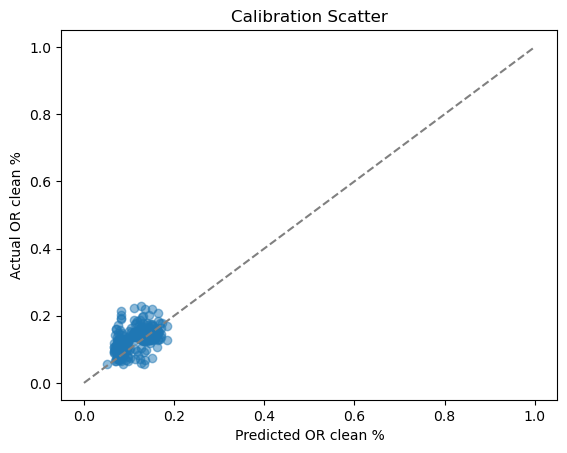

Top-decile lift: 1.18


In [31]:







# Calibration curve
plt.scatter(y_pred_or, y_test_rate, alpha=0.5)
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.xlabel("Predicted OR clean %")
plt.ylabel("Actual OR clean %")
plt.title("Calibration Scatter")
plt.show()

# Top-decile lift
df_test_eval = X_test.copy()
df_test_eval['y_pred'] = y_pred_or
df_test_eval['y_true_rate'] = y_test_rate

top_10pct = df_test_eval.sort_values('y_pred', ascending=False).head(int(len(df_test_eval)*0.1))
top_decile_mean = top_10pct['y_true_rate'].mean()
overall_mean = y_test_rate.mean()
lift = top_decile_mean / overall_mean
print(f"Top-decile lift: {lift:.2f}")


In [32]:
import pandas as pd
import statsmodels.api as sm
import ipywidgets as widgets
from IPython.display import display

# ---- 1️⃣ Prediction helper (unchanged) ----
def glm_predict_from_list(model, feature_values, feature_names):
    df_new = pd.DataFrame([feature_values], columns=feature_names)
    X_new = pd.get_dummies(df_new, drop_first=True)
    X_new = sm.add_constant(X_new, has_constant='add')
    model_cols = model.params.index
    for col in model_cols:
        if col not in X_new.columns:
            X_new[col] = 0
    X_new = X_new[model_cols]
    return model.predict(X_new)[0]


# ---- 2️⃣ Interactive predictor builder ----
def interactive_glm_predict(model, df, categorical_cols, numeric_cols):
    """
    Create an interactive UI for GLM predictions.

    Parameters
    ----------
    model : fitted statsmodels GLMResults
    df : pandas DataFrame used for training (to infer categories)
    categorical_cols : list of categorical feature names
    numeric_cols : list of numeric feature names
    """

    feature_names = categorical_cols + numeric_cols

    # Create widgets
    widgets_dict = {}

    for col in categorical_cols:
        # Suggested options from data
        options = sorted(df[col].dropna().unique().tolist())
        widgets_dict[col] = widgets.Dropdown(
            options=options, description=col, style={'description_width': '150px'}
        )

    for col in numeric_cols:
        widgets_dict[col] = widgets.FloatText(description=col, style={'description_width': '150px'})

    # Predict button + output display
    button = widgets.Button(description="Predict", button_style='success')
    output = widgets.Output()

    # On-click behavior
    def on_click(b):
        with output:
            output.clear_output()
            values = [widgets_dict[f].value for f in feature_names]
            pred = glm_predict_from_list(model, values, feature_names)
            print(f"Predicted open rate: {pred:.4f} ({pred*100:.2f}%)")

    button.on_click(on_click)

    # Layout
    form_items = list(widgets_dict.values())
    display(*(form_items + [button, output]))


In [ ]:
categorical_cols = [
     'Category name', 'Main vs REM', 'Personalization',
    'Emoji', 'Urgency', 'Tone', 'Price or Discount',
    'imperative ', 'product', 'Month','length of subject'
]

numeric_cols = ['Sendings', 'letter_count']

# Run interactive predictor
interactive_glm_predict(model_result, df, categorical_cols, numeric_cols)


Dropdown(description='Category name', options=('NL Final', 'NL Interval'), style=DescriptionStyle(description_…

Dropdown(description='Main vs REM', options=('MAIN', 'REM'), style=DescriptionStyle(description_width='150px')…

Dropdown(description='Personalization', options=('no', 'yes'), style=DescriptionStyle(description_width='150px…

Dropdown(description='Emoji', options=('no', 'yes'), style=DescriptionStyle(description_width='150px'), value=…

Dropdown(description='Urgency', options=('no', 'yes'), style=DescriptionStyle(description_width='150px'), valu…

Dropdown(description='Tone', options=('no', 'yes'), style=DescriptionStyle(description_width='150px'), value='…

Dropdown(description='Price or Discount', options=('no', 'yes'), style=DescriptionStyle(description_width='150…

Dropdown(description='imperative ', options=('no', 'yes'), style=DescriptionStyle(description_width='150px'), …

Dropdown(description='product', options=('no', 'yes'), style=DescriptionStyle(description_width='150px'), valu…

Dropdown(description='Month', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), style=DescriptionStyle(descript…

Dropdown(description='length of subject', options=('long', 'short'), style=DescriptionStyle(description_width=…

FloatText(value=0.0, description='Sendings', style=DescriptionStyle(description_width='150px'))

FloatText(value=0.0, description='letter_count', style=DescriptionStyle(description_width='150px'))

Button(button_style='success', description='Predict', style=ButtonStyle())

Output()

In [34]:
df.columns

Index(['Sent date', 'DD', 'Category name', 'Main vs REM', 'Sendings',
       'OR clean %', 'length of subject', 'Personalization', 'Emoji',
       'Urgency', 'Tone', 'Price or Discount', 'imperative ', 'product',
       'letter_count', 'Month', 'opens', 'fails'],
      dtype='object')